# XGBoost Architektur

#### Importe

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path

#### Gleichgewichtsdaten importieren

In [2]:
eq_data_file = Path.cwd().parent / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten
res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2,N2,NH3]
T = np.array(res['T'])
p = np.array(res['p'])
x_0 = np.array(res['x_0'])
x = np.array(res['x'])

#print(x_0)

X = np.stack((T, p, x_0[:,0], x_0[:,1], x_0[:,2]), axis = 1)
y = np.stack((x[:,0], x[:,2]), axis = 1) # [x_H2, x_NH3]
#print(X[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state = 42)

#print(y_train)

#### Normalisierung

In [3]:
# Preprocessing Normalisierung der Daten
mean_in = np.mean(X_train, 0) # Mittelwert
std_in = np.std(X_train, 0) # Standardabweichung
mean_out = y_train.mean()
std_out = np.std(y_train, 0)

X_train = (X_train - mean_in) / std_in
y_train = (y_train - mean_out) / std_out

X_test = (X_test -mean_in) / std_in
y_test = (y_test - mean_out) / std_out

# print(mean_in)
# print(std_in)
# print(X_train)
# print(np.mean(X_train[:,0]))

#### XGBoost Modell

In [4]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train, eval_set = [(X_test, y_test)])

score_xgb_train = xgb_model.score(X_train, y_train)
score_xgb_test = xgb_model.score(X_test, y_test)
print('R^2 Train:', score_xgb_train)
print('R^2 Test:', score_xgb_test)

[0]	validation_0-rmse:1.39883
[1]	validation_0-rmse:1.00575
[2]	validation_0-rmse:0.73220
[3]	validation_0-rmse:0.53905
[4]	validation_0-rmse:0.40276
[5]	validation_0-rmse:0.30951
[6]	validation_0-rmse:0.24466
[7]	validation_0-rmse:0.20285
[8]	validation_0-rmse:0.17621
[9]	validation_0-rmse:0.15708
[10]	validation_0-rmse:0.14507
[11]	validation_0-rmse:0.13657
[12]	validation_0-rmse:0.13312
[13]	validation_0-rmse:0.12888
[14]	validation_0-rmse:0.12647
[15]	validation_0-rmse:0.12441
[16]	validation_0-rmse:0.12277
[17]	validation_0-rmse:0.12242
[18]	validation_0-rmse:0.12172
[19]	validation_0-rmse:0.12087
[20]	validation_0-rmse:0.12027
[21]	validation_0-rmse:0.11960
[22]	validation_0-rmse:0.11912
[23]	validation_0-rmse:0.11886
[24]	validation_0-rmse:0.11863
[25]	validation_0-rmse:0.11827
[26]	validation_0-rmse:0.11813
[27]	validation_0-rmse:0.11776
[28]	validation_0-rmse:0.11748
[29]	validation_0-rmse:0.11735
[30]	validation_0-rmse:0.11692
[31]	validation_0-rmse:0.11672
[32]	validation_0-

#### Vorhersage Gleichgewichtsdaten

In [5]:
# Vorhersage der GGW Daten
pred_train_norm = xgb_model.predict(X_train)
pred_test_norm = xgb_model.predict(X_test)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()

print('MAE Train:', mae_train, 'MRE Train:', mre_train, 'MAE Test:', mae_test, 'MRE Test:', mre_test)

MAE Train: 0.0004050488438749933 MRE Train: 0.00205160586648942 MAE Test: 0.01057607884836991 MRE Test: 0.05034585056149409


#### Parity Plot

Training Dataset: R^2 = 0.9999787921303802
Test Dataset: R^2 = 0.9866550692854469
Max Error Training: |x_H2 - x_H2_pred| = 0.0012626636045676154 |x_NH3 - x_NH3_pred| = 0.0013400607900410366
Max Error Test: |x_H2 - x_H2_pred| = 0.002926679037508373 |x_NH3 - x_NH3_pred| = 0.04725456020597768


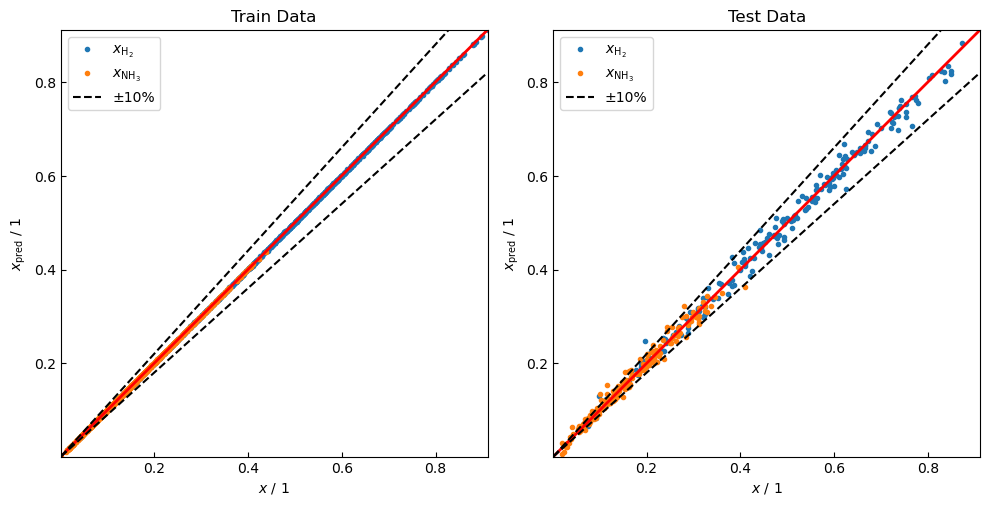

In [6]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### GridSearch CV

In [10]:
# Liste der zu tunenden Hyperparameter
params = {"objective": ["reg:squarederror", "reg:squaredlogerror", "reg:logistic", "reg:pseudohubererror", "reg:absoluteerror"],
          "max_depth": [3, 5, 6, 10, 15], #default=6
          "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4], #default= 0.3
          "colsample_bytree": np.arange(0.4, 1.0, 0.1), #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "subsample": np.arange(0.5, 1.0, 0.1), #default=1  fraction of observations to be sampled for each tree
          "colsample_bylevel": np.arange(0.4, 1.0, 0.1),
          "n_estimators": [50, 100, 150]
         }

# Neues XGBoost Objekt
knn_model_2 = xgb.XGBRegressor()

model = RandomizedSearchCV(knn_model_2, params, n_iter=25)
best_model = model.fit(X_train, y_train)

print('Best parameters:', best_model.best_params_)
best_objective = best_model.best_estimator_.get_params()['objective']
best_max_depth = best_model.best_estimator_.get_params()['max_depth']
best_learning_rate = best_model.best_estimator_.get_params()['learning_rate']
best_colsample_bytree = best_model.best_estimator_.get_params()['colsample_bytree']
best_subsample = best_model.best_estimator_.get_params()['subsample']
best_colsample_bylevel = best_model.best_estimator_.get_params()['colsample_bylevel']
best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

# print('Best n_neighbors:', best_k)
# print('Best weights:', best_weights)
# print('Best algorithm:', best_algorithm)
# print('Best leaf_size:', best_leaf_size)
# print('Best p:', best_p)

C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
65 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\sinar\anaconda3\envs\BA\lib

Best parameters: {'subsample': 0.6, 'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}


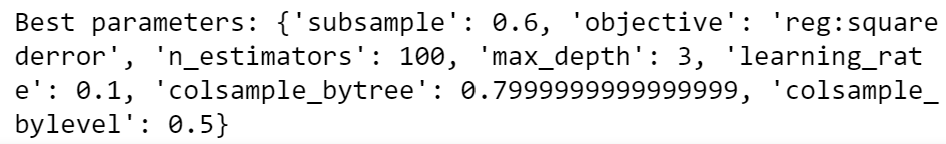

#### Best Model

In [14]:
xgb_model_2 = xgb.XGBRegressor('subsample': 0.6, 'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5) # Initialisierung
#xgb_model_2 = xgb.XGBRegressor(best_model.best_params_) # Initialisierung

xgb_model_2.fit(X_train, y_train, eval_set = [(X_test, y_test)])

score_xgb_train = xgb_model.score(X_train, y_train)
score_xgb_test = xgb_model.score(X_test, y_test)
print('R^2 Train:', score_xgb_train)
print('R^2 Test:', score_xgb_test)

SyntaxError: invalid syntax (2789226507.py, line 1)